# In-Depth Introduction to Turing

This is an in-depth introduction to the [Turing.jl](https://turing.ml) a high-level probabilistic programming language written in [Julia](https://julialang.org). We will begin by building a simple model and then exploring the inference interface, before exploring the backend syntax of `@model`, the kinks and quirks of the automatic differentiation backend, how to express our probabilistic models performantly and visualizing our results

The tutorial is based on the [Turing tutorials](https://turing.ml/dev/docs/using-turing) and material from the [Zygote.jl](https://github.com/FluxML/Zygote.jl) [documentation](https://fluxml.ai/Zygote.jl/dev/) on automatic differentiation.

## Starting in Turing

We begin by importing our dependencies:

In [1]:
using Turing
using StatsPlots
using Distributed

Distributions of random variables are defined by `x ~ distribution`. If `x` is already defined Turing views this as us conditioning on `x` having been drawn from this distribution. The likelihood is always computed using the `logpdf`.

We begin by defining a normal model with unknown mean and variance

In [2]:
@model function gdemo(x, y)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    x ~ Normal(m, sqrt(s))
    y ~ Normal(m, sqrt(s))
end

DynamicPPL.ModelGen{var"###generator#275",(:x, :y),(),Tuple{}}(##generator#275, NamedTuple())

Inference is performed using the `sample` statement to which we provide our probabilistic program as the first argument, and the sampler as the second argument. The available samplers are:
* Gibbs-sampler
* Hamiltonian Monte-Carlo sampler
* Hamiltonian Monte-Carlo sampler with Dual Averaging algorithm
* Importance sampling
* No-U-Turn sampler
* Particle Gibbs sampler
* Sequential Monte Carlo sampler

Using the `DynamicPPL.Sampler` interface we are furthermore able to implement our own inference algorithms for which we need to specify the type of the algorithm and parameters with inheritance from `InferenceAlgorithm` and a `sample` method.

In [3]:
c1 = sample(gdemo(1.5, 2), SMC(), 1000)
c2 = sample(gdemo(1.5, 2), PG(10), 1000)
c3 = sample(gdemo(1.5, 2), HMC(0.1, 5), 1000)
c4 = sample(gdemo(1.5, 2), Gibbs(PG(10, :m), HMC(0.1, 5, :s)), 1000)
c5 = sample(gdemo(1.5, 2), HMCDA(0.15, 0.65), 1000)
c6 = sample(gdemo(1.5, 2), NUTS(0.65), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:   1%|▌                                        |  ETA: 0:00:20┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, fals

Object of type Chains, with data of type 500×14×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = m, s

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           m  1.2102  0.7617    0.0341  0.0381  335.5709  0.9989
           s  1.7978  1.3578    0.0607  0.0711   39.3930  1.0003

Quantiles
  parameters     2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ──────  ──────  ──────  ──────
           m  -0.2069  0.7460  1.2047  1.6379  2.8148
           s   0.5539  1.0072  1.5017  2.1530  5.1656


Where the APIs for each of the inference algorithms is defined as:

### Gibbs-Sampler

Args:
* multiple inference algorithms, which to be combined by the Gibbs sampler. This allows us to use particle-based methods, like `PG` for discrete variables and `HMC` for continuous variables.

### Hamiltonian Monte-Carlo

Args:
* leapfrog step size to use, which is to be reduced when receiving gradient errors
* number of leapfrog steps to use

### Hamiltonian Monte-Carlo Dual-Averaging

Args:
* Number of samples to use for adaptation
* Target acceptance rate, a good guess is usually 65%
* Target leapfrog length
* Initial step size, if the step size is 0 Turing automatically searches for the optimal step size

### Importance Sampling

Args:
* Requires no arguments

### No-U-Turn Sampler

Args:
* Number of samples to use with adaptation
* Target acceptance rate for dual averaging
* Maximum doubling tree depth
* Maximum divergence during double tree
* Initial step size, if the step size is 0 Turing automatically searches for the optimal step size

### Particle-Gibbs

Args:
* Number of particles
* Optionally a custom resampling algorithm

### Sequential Monte Carlo

Args:
* Requires no arguments, but can optionally specify a custom resampling algorithm

Viewing summary statistics for one of the sampled chains:

In [4]:
describe(c3)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           m  1.1841  0.8475    0.0268  0.1024   89.0325  1.0057
           s  2.1883  1.7679    0.0559  0.1243  183.3821  1.0008

Quantiles
  parameters     2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ──────  ──────  ──────  ──────
           m  -0.4307  0.6272  1.1781  1.6763  3.0430
           s   0.5946  1.1058  1.6328  2.6009  7.2927


Plotting results:

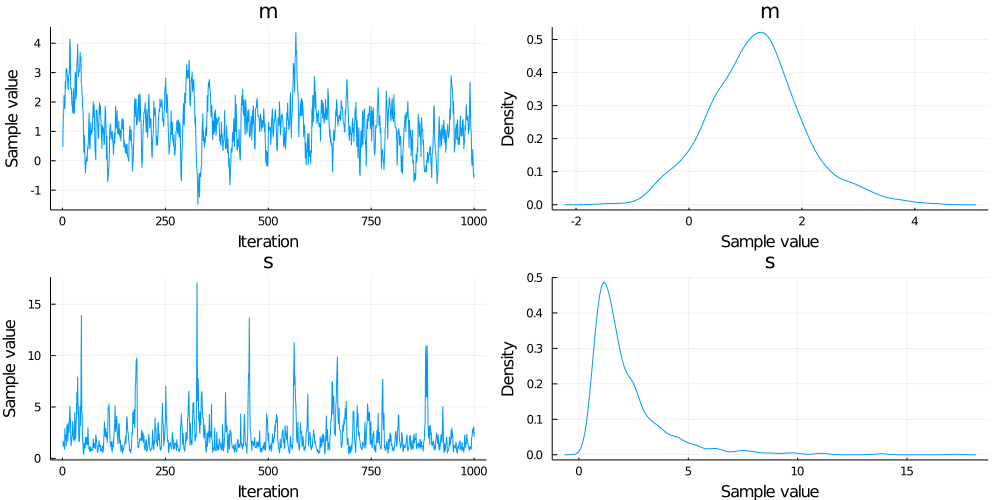

In [5]:
plot(c3)

## Modeling Syntax

The order in which we write out the model code matters. In this example `s` needs to be declared before `y`, as `y`
uses the sampled result from `s`.

In [6]:
@model function example(y)
    s ~ Poisson(1)
    y ~ Normal(s, 1)  # 
    return y
end

sample(example(10), SMC(), 100)

Object of type Chains, with data of type 100×4×1 Array{Float64,3}

Log evidence      = -17.32891100468532
Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = le, lp, weight
parameters        = s

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se     mcse  ess  r_hat
  ──────────  ──────  ──────  ────────  ───────  ───  ─────
           s  5.0000  0.0000    0.0000  missing  NaN    NaN

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
           s  5.0000  5.0000  5.0000  5.0000  5.0000


## Sampling with Multiple Chains

With Turing we employ threaded, as well as parallel sampling to fully exploit the computational resources available to use. This is defined in the `sample` statement with an extra argument inside of the call, i.e. `sample(model, sampler, {MCMCThreads(), MCMCDistributed()}, n, n_chains)`. With multiple chains we can then evaluate convergence characteristics. If parallelism is not desired, one can still sample multiple chains through the `mapreduce` function.

As the `chains` variable now contains multiple chains, which can be indexed by chain, e.g. for the first chain `chains[:, :, 1]`.

For multithreaded sampling with 4 chains in this example, for which the Julia instance needs to be started with multiple threads to actually "fill" those threads:

In [22]:
@model function multithreading_demo(x)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

model = multithreading_demo([1.5, 2.0])

chain = sample(model, NUTS(), MCMCThreads(), 1000, 4; save_state=true)

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


Object of type Chains, with data of type 500×14×4 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = m, s

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
           m  1.1341  0.8235    0.0184  0.0249  1046.4862  1.0039
           s  2.1115  1.9193    0.0429  0.0691   944.7420  1.0057

Quantiles
  parameters     2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ──────  ──────  ──────  ──────
           m  -0.5758  0.6445  1.1392  1.6279  2.8604
           s   0.5580  1.0526  1.5432  2.4529  7.1450


Using distributed sampling with four sampling parallel sampling processes and enforcing a precompiled Turing on all processes.

In [8]:
addprocs(4)

@everywhere using Turing

@everywhere @model function distributed_demo(x)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

@everywhere model = distributed_demo([1.5, 2.0])

#sample(model, NUTS(), MCMCDistributed(), 1000, 4) --> Takes way too long, bug?

To sample from a model's prior we can simply generate a chain out of the prior, i.e. `chain = sample(model, Prior(), n_samples)`. We are furthermore able to run our model from the prior distribution, by calling the model without specifying inputs or a sampler. Our example model returns two variables, but also takes two variables as input. Not specifying the two leads Turing to believe that they are missing values, which are to be drawn from the respective distribution.

In [9]:
@model function unconditional_demo(x, y)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    x ~ Normal(m, sqrt(s))
    y ~ Normal(m, sqrt(s))
    return x, y
end

unconditional_prior_sample = unconditional_demo(missing, missing)
unconditional_prior_sample()

(0.7121068860679237, 0.789046519224088)

To sample from a model's posterior, i.e. treat observations as random variables we have to express our model
with the following syntax, where the missing variable needs to be initialized explicitly:

In [28]:
@model function conditional_demo(x, ::Type{T} = Float64) where {T}
    if x === missing
        # Initialize `x` if missing
        x = Vector{T}(undef, 2)
    end
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

# Construct a model with x = missing
model = gdemo(missing)
c = sample(model, HMC(0.01, 5), 500)

Object of type Chains, with data of type 500×13×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size
parameters        = m, s, x[1], x[2]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse     ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ──────  ──────
           m   2.6073  0.5460    0.0244  0.2588  2.6573  1.8842
           s   5.3517  2.5394    0.1136  1.0998  2.7435  1.7020
        x[1]   1.9024  0.6157    0.0275  0.2915  2.0689  2.4969
        x[2]  -2.0367  0.4349    0.0194  0.1979  2.1829  2.1529

Quantiles
  parameters     2.5%    25.0%    50.0%    75.0%    97.5%
  ──────────  ───────  ───────  ───────  ───────  ───────
           m   1.6059   2.2610   2.5717   2.8528   3.6180
           s   2.4522   3.3170  

It is also possible to use a mixture of `missing` and non-`missing` values in the same random variable `x`. The missing entries will be treated as random variables to be sampled, while non-`missing` values get treated as observations

In [11]:
@model function conditional_missing_demo(x)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

model = conditional_missing_demo([missing, 2.4])
c = sample(model, HMC(0.01, 5), 500)

Object of type Chains, with data of type 500×12×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size
parameters        = m, s, x[1]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse      ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ───────  ──────
           m  0.8264  0.2874    0.0129  0.0888  13.3413  1.0003
           s  0.8821  0.2562    0.0115  0.0910   8.4612  1.0750
        x[1]  0.1796  0.3688    0.0165  0.1568   2.1688  1.8987

Quantiles
  parameters     2.5%    25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ───────  ──────  ──────  ──────
           m   0.1751   0.6294  0.8754  1.0419  1.2526
           s   0.2975   0.7136  0.9301  1.0632  1.3378
        x[1]  -0.4676  -0.1192  0.1702  0.5051  0.7814


To treat an observation by default as a random variable, we can specify such trait in the model definition

In [12]:
@model function conditional_default_demo(x = missing, ::Type{T} = Float64) where {T <: Real}
    if x === missing
        x = Vector{T}(undef, 10)
    end
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
    return s, m
end

m = conditional_default_demo()
chain = sample(m, HMC(0.01, 5), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Object of type Chains, with data of type 1000×21×1 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size
parameters        = m, s, x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse      ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ───────  ──────
           m   0.3099  0.3104    0.0098  0.0834  15.7683  1.0426
           s   1.4595  0.8300    0.0262  0.2558   4.0814  1.8383
        x[1]   0.3740  1.1287    0.0357  0.3680   4.0161  3.0580
        x[2]  -1.8862  0.8106    0.0256  0.2610   4.0161  3.0453
        x[3]   0.2873  0.3975    0.0126  0.1168   9.0525  1.1137
        x[4]   0.2230  0.5025    0.0159  0.1538   7.8475  1.0071
        x[5]   1.5903  0.4748

### The Chain as a Datastructure

Values stored inside of a chain can be accessed in multiple ways:

1. Transform them into `DataFrames`
2. Use their raw `AxisArray` form
3. Create a three-dimensional `Array` object

When defining the variable types we need to abide by a few rules:

1. When using the Hamiltonian sampler we should use `real` values to enable auto-differentiation through the model
2. When using a particle sampler variables should preferably be 'TArray's
3. Use the type parameter definition in the model header

### Querying Probabilities from our Model, or our Chain

When having a demo model we can query the model and its likelihoods in a multitude of ways using the `prob` command, if we are interested in log-probabilities you just need to replace `prob` with `logprob` below.

In [13]:
@model function probability_query_demo(x, y)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    x ~ Normal(m, sqrt(s))
    y ~ Normal(m, sqrt(s))
end

DynamicPPL.ModelGen{var"###generator#429",(:x, :y),(),Tuple{}}(##generator#429, NamedTuple())

Calculate the likelihood of `x=1`and `y=1` given `s=1` and `m=1`

In [14]:
prob"x=1.0, y=1.0 | model=probability_query_demo, s=1.0, m=1.0"

0.15915494309189532

Calculate the joint probability of `s=1` and `m=1` ignoring `x` and `y`, so they can optionally be dropped.

In [15]:
prob"s=1.0, m=1.0 | model=probability_query_demo, x=nothing, y=nothing"

0.10842311704190549

Calculate the joint probability of `s=1`, `m=1` and `x=1` ignoring `y`

In [16]:
prob"s=1.0, m=1.0, x=1.0 | model=probability_query_demo, y=nothing"

0.043254565560929215

Calculate the joint probability of all variables

In [17]:
prob"s=1.0, m=1.0, x=1.0, y=1.0 | model=probability_query_demo"

0.017256075022650377

The same can be done for chains after MCMC sampling has taken place. E.g. calculating the element-wise likelihood of `x=1.0` and `y=1.0` for each sample in the chain `prob"x=1.0, y=1.0 | chain=chain, model=multithreading_demo"` or `prob"x=1.0, y=1.0 | chain=chain"` if `save_state=true` was set at sampling time.

### Maximum Likelihood and Maximum a Posterior Estimates

For mode estimation Turing provides maximum likelihood estimation (MLE) and maximum a posterior (MAP) estimation. To benefit from these capabilities, we need to load the `Optim` package. For mode estimation to work all parameters furthermore need to be continuous.

In [31]:
using Optim

In [32]:
@model function mode_demo(x)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

DynamicPPL.ModelGen{var"###generator#541",(:x,),(),Tuple{}}(##generator#541, NamedTuple())

In [33]:
data = [1.5, 2.0]
model = mode_demo(data)

DynamicPPL.Model{var"###evaluator#540",(:x,),Tuple{Array{Float64,1}},(),DynamicPPL.ModelGen{var"###generator#541",(:x,),(),Tuple{}}}(##evaluator#540, (x = [1.5, 2.0],), DynamicPPL.ModelGen{var"###generator#541",(:x,),(),Tuple{}}(##generator#541, NamedTuple()))

Benefitting from `Optim.optimize` Turing accepts `MLE()` or `MAP`. The optimizer uses LBFGS by default.

In [34]:
mle_estimate = optimize(model, MLE())
map_estimate = optimize(model, MAP())

ModeResult with minimized lp of -4.62
2-element Named Array{Float64,1}
A  │ 
───┼─────────
s  │ 0.907407
m  │  1.16667

The optimizer can be altered by using the optional third argument and putting an alternative such as

* NelderMead
* SimulatedAnnealing
* ParticleSwarm
* Newton
* AcceleratedGradientDescent

If Optim fails to converge, it is prudent to increase the number of possible `iterations` or allow for steps that increase the objective value by setting `allow_f_increase` to true in an additional argument. This would then look like this:

In [36]:
mle_estimate = optimize(model, MLE(), Newton(), Optim.Options(iterations=10_000, allow_f_increases=true))

ModeResult with minimized lp of -0.07
2-element Named Array{Float64,1}
A  │ 
───┼───────
s  │ 0.0625
m  │   1.75

Turing benefits from inheritance from the `StatsBase` package, which provides analysis tools to dissect the mode estimation results. The most prevalent of which are coefficient-tables (`coeftable`), and the Fisher information matrix (`informationmatrix`). E.g. using the coefficient table

In [40]:
using StatsBase

In [41]:
coeftable(mle_estimate)

──────────────────────────────
   estimate  stderror    tstat
──────────────────────────────
s    0.0625  0.0625    1.0
m    1.75    0.176777  9.89949
──────────────────────────────

We can also begin sampling a chain from the MLE/MAP estimate. For this we have to extract the vector of parameter values and provide it to the `sample` function to `init_theta`. E.g. sampling from the full posterior using the MAP estimate

In [42]:
map_estimate = optimize(model, MAP())
chain = sample(model, NUTS(), 1_000, init_theta=map_estimate.values.array)

┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Info: Using passed-in initial variable values
│   init_theta = [0.9074074074333142, 1.166666666879435]
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/Inference.jl:280
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Object of type Chains, with data of type 500×14×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = m, s

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           m  1.1977  0.7275    0.0325  0.0200  276.0720  0.9985
           s  1.8841  1.3472    0.0603  0.0542  290.3314  1.0028

Quantiles
  parameters     2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ───────  ──────  ──────  ──────  ──────
           m  -0.5190  0.7936  1.2351  1.6313  2.6770
           s   0.5237  1.0536  1.4901  2.3188  5.1089


### Diagnostics of Chains using MCMCChains.jl

Turing's samples are wrapped by `MCMCChains.Chain`, hence allowing the analysis of chains using all available diagnostics from [MCMCChains](https://github.com/TuringLang/MCMCChains.jl). Examples of available functionality include, but are not limited to:

Convergence diagnostics such as:
* Gelman, Rubin, and Brooks Diagnostics
* Geweke Diagnostics
* Heidelberger and Welch Diagnostics
* Raftery and Lewis Diagnostics

Model selection with the *Deviance Information Criterion (DIC)*, plotting support and multiple ways to export chains into `Array` structures or `DataFrame` structures.

## Advanced Interfaces

### Customized Distributions

While Turing support a wide array of distributions through the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package, it allows for the custom definition of distributions by benefitting from subtypes of `Distribution`, which then have to be complemented with corresponding functions. E.g. if we were to define a uniform distribution it would look like this:

In [ ]:
struct CustomUniform <: ContinuousUnivariateDistribution
end

# Define rand and logpdf
Distributions.rand(rng::AbstractRNG, d::CustomUniform) = rand(rng)
Distributions.logpdf(d::CustomUniform, x::Real) = zero(x)

As `HMC` requires the domain of priors to be unbounded we furthermore need to define a bijector from `[0, 1]` to `ℝ`. For this we have to use the [`Bijectors.jl`](https://github.com/TuringLang/Bijectors.jl) package, i.e.

In [ ]:
Bijectors.bijector(d::CustomUniform) = Logit(0., 1.)

In the uniform case we furthermore want to define the minimum and maximum

In [ ]:
Distributions.minimum(d::CustomUniform) = 0.
Distributions.maximum(d::CustomUniform) = 1.

For performance-oriented implementations it is furthermore recommended to implement vectorization support.

### Model Internals